# Learning PageRank

### Overview

This Jupyter Notebook covers the **implementation of two simple Graph Neural Networks** (GNN) that are able to learn and determine the PageRank value of a graph.

As such, the repository covers:
- A program to compute the PageRank value of a given graph
- A random graph generator based on Erdos' random graph and scale-free generation
- A GNN with relaxation
- A GNN with a convolutional graph approach

The python implementations are available in the `script` folder and will be imported in this notebook. 

#### Note & Citation

This notebook relies heavily on the `networkx` library:

> Aric A. Hagberg, Daniel A. Schult and Pieter J. Swart, “Exploring network structure, dynamics, and function using NetworkX”, in Proceedings of the 7th Python in Science Conference (SciPy2008), Gäel Varoquaux, Travis Vaught, and Jarrod Millman (Eds), (Pasadena, CA USA), pp. 11–15, Aug 2008

### Library imports

```sh
pip install dgl==0.6.1
pip install torch==1.9.1
```

In [1]:
import networkx as nx
import numpy as np

from scripts.dataset import concatenate_graph_dataset
from scripts.dataset import generate_graph_dataset
from scripts.dataset import load_concatenated_graph_dataset
from scripts.dataset import PageRankDataset
from scripts.functions import generate_erdos_graph
from scripts.functions import generate_scale_free_graph
from scripts.functions import plot_graph
from scripts.graph_networks import PageRankModelingWithGNN
from scripts.page_rank import page_rank
from scripts.random_graph_generator import Random_Graph_Generator

%matplotlib inline

Using backend: pytorch


## 1. Implementing a Custom PageRank Function

### 1.1. The Concept of PageRank

#### Overview

PageRank or $PR$ is an link analysis algorithm used by Google to rank web pages. 

Considering pages as node of a (web)graph, hyperlinks or references between pages are considered as edges of said graph. The PageRank of a node is the numerical weight representing the importance of the node in the graph, which is computed by the number of incoming link to the node existing within the graph itself. 

> Page, Lawrence and Brin, Sergey and Motwani, Rajeev and Winograd, Terry (1999) The PageRank Citation Ranking: Bringing Order to the Web. Technical Report. Stanford InfoLab.

#### Overview of the Algorithm

The PageRank algorithm is recursive as any PageRank value of a node of a graph is derived from the PageRank values of other nodes. 

<u>Initialization:</u>

Given a graph $G$ with nodes $\forall i\in\{0,1,\ldots,n\}, N_i\in G$. Edges corresponds to links between each nodes (no node self-references). Each node is initialized with a PageRank value drawn from a probability distribution with domain $[0,1]$ and summing to 1. 

A node $N_i$ transfers its PageRank value to the node $N_j$ it references (i.e. via an outbound link $N_i\rightarrow N_j$). The value transfer is done in equal proportion between each link $\forall j\in\{0,\ldots,n\},i\neq j, N_i\rightarrow N_j$. 

<u>Page Rank computation:</u>

As such, the PageRank amount granted to a node $N_j$ from a node $N_i$ via an outbound link $N_i\rightarrow N_j$ is:

$\forall i, j\in\{0,1,\ldots,n\},i\neq j,$
\begin{align}
N_i, N_j&\in G\\
PR_{\text{transferred},\,N_i\rightarrow N_j}(N_i)&=\frac{PR(N_i)}{L(N_i)}\\
L(N_i)&=\overset{n}{\underset{i=0\\i\neq j}{\sum}}\mathbb{1}_{\exists N_i\rightarrow N_j}
\end{align}

Consequently, the PageRank value of a single node $N_i$ is:

$$\forall i, j\in\{0,1,\ldots,n\},i\neq j,\,PR(N_i)=\frac{1-d}{n}+d\big(\overset{n}{\underset{j\in\mathcal{M}(i)}{\sum}}PR_{\text{transferred},\,N_j\rightarrow N_i}(N_j)\big)$$

With $\mathcal{M}(i)$ the set of nodes $N_j$ that link to node $N_i$, $d$ a damping vactor (often set to $0.85$) that captures the idea that a random walker on the web will continue clicking on links on a page/node as a reducing rate.

#### Note on PageRank and Message Passing Models

We find some similarities between the way PageRank is computed and a generic model description of Graph Neural Networks based on message exchange among neighbors. Many GNN models can be described using this formalism called *Message Passing*, which helps understand how information propagates within a graph.

<center><img src="assets/message_passing.gif" width="400"></center>

### 1.2. Iterative Implementation

We decide to implement PageRank's iterative method described as such:

#### Initialization

- $n$, the number of nodes in the graph
- $t=0$, the starting timestep
- $\forall i\in\{0, \ldots, n\},\,PR(N_i; t=0)=\frac{1}{n}$, the starting PageRank of a node $N_i$ at time $t=0$
- $d\in[0, 1]$, the damping factor (usually set to $0.85$)
- $\epsilon$, an error parameter used to stop the algorithm

#### Iterative Steps

At each time step,

\begin{align}
\forall i\in\{0, \ldots, n\},\,PR(N_i; t+1)&=\frac{1-d}{n}+d\big(\overset{n}{\underset{j\in\mathcal{M}(i)}{\sum}}\frac{PR(N_j)}{L(N_j)}\big)\\
\end{align}

We denote $R(t)$ the column vector of length $n$ which row values are $\forall i \in \{0, \ldots, n\}, PR(N_i; t)$.

#### Iteration Stop

The above iterative process stops when: $$|R(t+1)-R(t)|<\epsilon$$

This assumes that the process has converged.

#### Example implementation

The full code is avalaible in the file `scripts/page_rank.py`.

In [2]:
# Generates a probabilistic transition matrix M
# of a graph with 10 nodes
M = np.random.random(size=(10, 10))
N = np.random.randint(0, 2, size=(10, 10))
M = M*N # adds zeros
M = M/M.sum(axis=0) # sums columns to one

print("Transition matrix M:\n", np.round(M, 1))

Transition matrix M:
 [[0.  0.  0.2 0.1 0.1 0.  0.1 0.  0.  0. ]
 [0.3 0.2 0.  0.3 0.  0.6 0.  0.2 0.  0. ]
 [0.  0.2 0.  0.1 0.  0.  0.2 0.  0.6 0.3]
 [0.  0.1 0.  0.  0.  0.  0.  0.  0.  0.1]
 [0.4 0.1 0.  0.  0.  0.  0.2 0.  0.1 0.3]
 [0.  0.2 0.3 0.2 0.8 0.  0.  0.1 0.3 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.3 0.  0. ]
 [0.2 0.  0.  0.  0.1 0.4 0.2 0.  0.  0. ]
 [0.  0.  0.  0.3 0.  0.  0.3 0.2 0.  0.1]
 [0.1 0.2 0.5 0.  0.  0.  0.  0.1 0.  0.1]]


In [3]:
# Computes the PageRank of each of the 10 nodes
page_rank(M, print_convergence=True)

PageRank converged at iteration 11 with epsilon=1e-05.


array([[0.05007246],
       [0.17340621],
       [0.12028379],
       [0.0460129 ],
       [0.09382415],
       [0.17170493],
       [0.05285208],
       [0.10204559],
       [0.07006628],
       [0.1197316 ]])

## 2. Generating Random Graphs

### 2.1. Generating an Example Erdos Graph

In [4]:
g = generate_erdos_graph(10, 0.3)

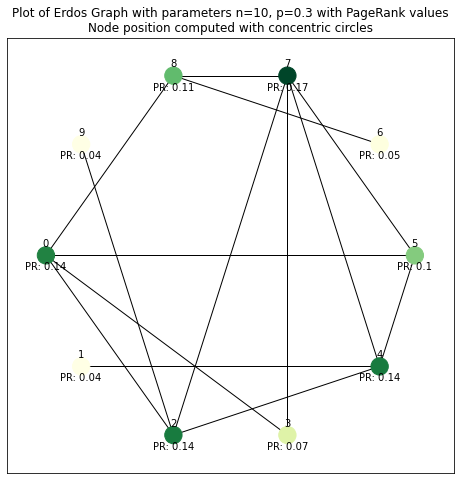

In [5]:
plot_graph(g, layout="shell")

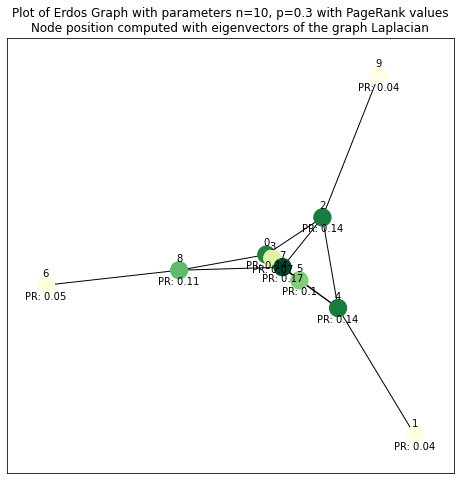

In [6]:
plot_graph(g, layout="spectral")

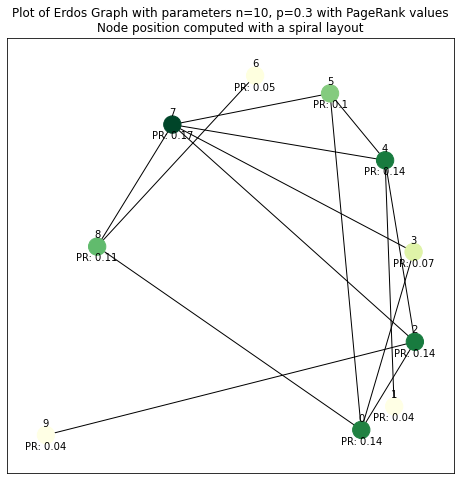

In [7]:
plot_graph(g, layout="spiral")

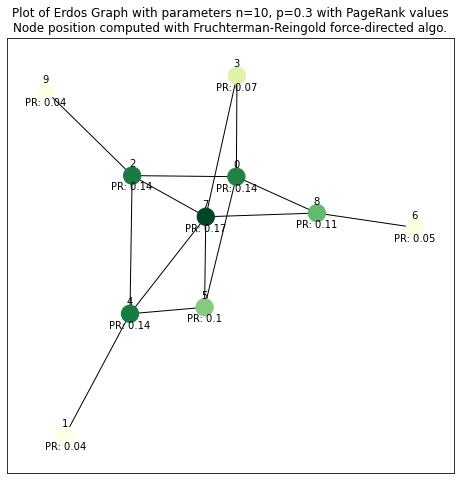

In [8]:
plot_graph(g, layout="spring")

### 2.2. Generating an Example Scale-Free Graph

In [9]:
g = generate_scale_free_graph(10)

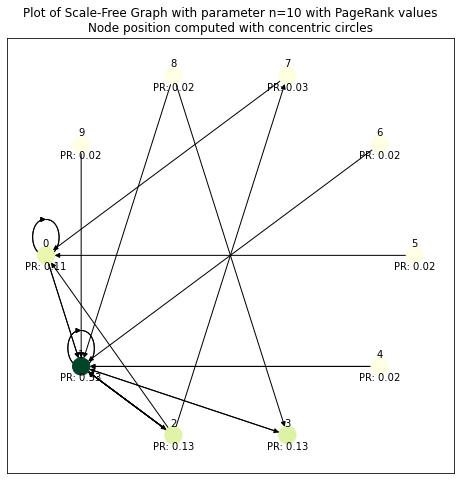

In [10]:
plot_graph(g, layout="shell")

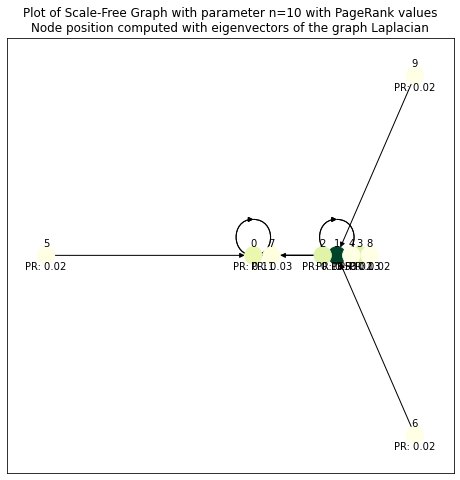

In [11]:
plot_graph(g, layout="spectral")

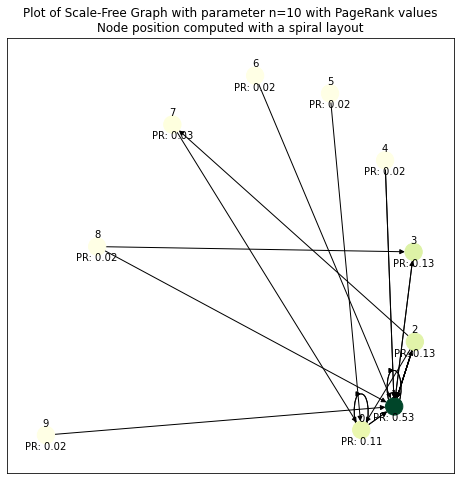

In [12]:
plot_graph(g, layout="spiral")

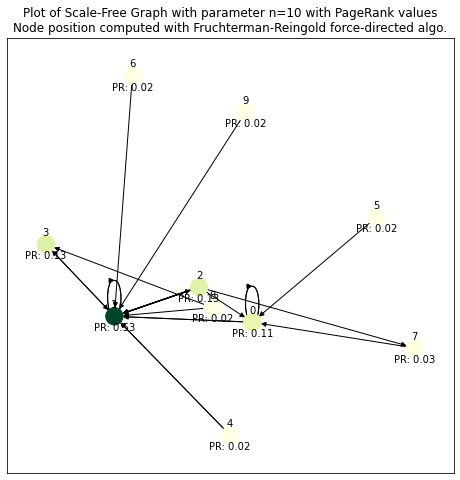

In [13]:
plot_graph(g, layout="spring")

### 2.2. Many Graphs Generation

#### Erdos' Method

The Erdős-Rényi graph or a binomial graph is a graph model that construct a graph $G_{n,p}$ where each of the possible edges between $n$ nodes appear with a fixed probability $p$. Each edge's probability of appearance is independent from the other edge's own probabilities.

> P. Erdős and A. Rényi, On Random Graphs, Publ. Math. 6, 290 (1959).

<u>Example</u>

In [14]:
erdos_generator = Random_Graph_Generator("erdos", True)
erdos_generator.graphs_generate(100, 5, 0.5)
erdos_generator.graphs_page_rank_compute()
eX, ey = erdos_generator.graphs_retrieve()

Erdos Graph Generator declared
5 graphs were generated
PageRank values computed


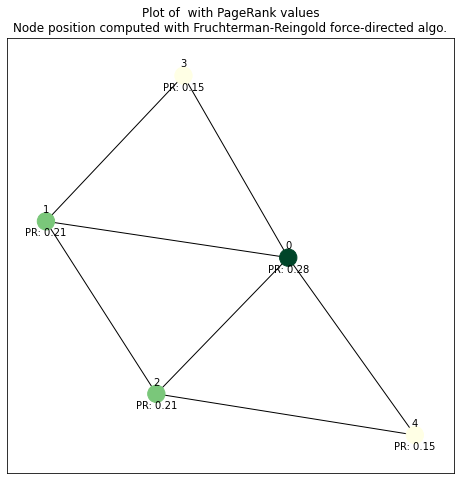

{0: 0.2770643638571485,
 1: 0.21240875912407128,
 2: 0.21240875912407128,
 3: 0.1490590589473544,
 4: 0.1490590589473544}

In [15]:
plot_graph(eX[50])
ey[50]

#### Scale-Free Method

The Scale-Free graph is a graph model that construct a graph $G_{n}$ of $n$ nodes with the property that the number of links $k$ originating from a given node exhibits a power law distribution $P(k)\sim k^(-\gamma)$. 

A scale-free network can be constructed by progressively adding nodes to an existing network and introducing links to existing nodes with preferential attachment so that the probability of linking to a given node $i$ is proportional to the number of existing links $k_i$ that node has such that:

$$P(\text{linking to node }i)\sim\frac{k_i}{\sum_jk_j}$$

> B. Bollobás, C. Borgs, J. Chayes, and O. Riordan, Directed scale-free graphs, Proceedings of the fourteenth annual ACM-SIAM Symposium on Discrete Algorithms, 132--139, 2003.

<u>Example</u>

In [16]:
scalefree_generator = Random_Graph_Generator("scale-free", True)
scalefree_generator.graphs_generate(100, 5)
scalefree_generator.graphs_page_rank_compute()
sfX, sfy = scalefree_generator.graphs_retrieve()

Scale-Free Graph Generator declared
5 graphs were generated
PageRank values computed


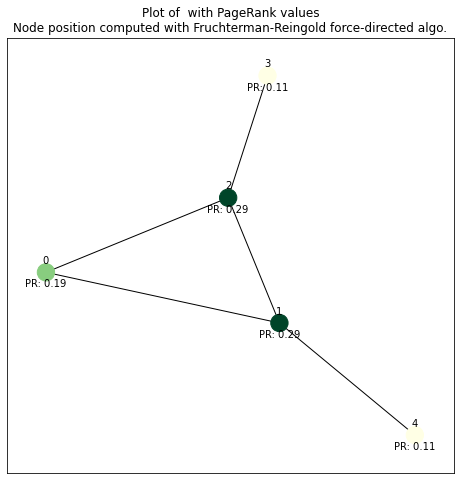

{0: 0.19457480653917453,
 1: 0.2904251934608255,
 2: 0.2904251934608255,
 3: 0.11228740326958728,
 4: 0.11228740326958728}

In [17]:
plot_graph(sfX[50])
sfy[50]

## 3. Learning PageRank

### 3.1. Building a Dataset
    
<u>Parameter selection</u>

To construct a dataset, we select:

- A **range of nodes $N$** to modulate the number of nodes in the graphs we want to create
- A selection of **graph-generating methods**. In our case: 
    - Erdos' method
    - Scale-Free method
- A **range of parameter values** for each parameter used to generate the graphs. In our case:
    - A range of probabilities $P$ to generate Erdos graphs
- A **number of graphs** to generate $n_{method}$ ***per given case and method***. In our case:
    - Erdos' method: we will obtain $n_{\text{erdos}}*len(P)*len(N)$
    - Scale-Free method: we will obtain $n_{\text{scale-free}}*len(N)$

As such, we choose to generate graphs with a 50/50 split between Erdos and Scale-Free graphs:

| Parameters | Description | Value | 
| :---: | :---: | :---: |
| P | Range of probabilities to generate Erdos graphs | {0.2, 0.3, 0.4, 0.5} |
| N |  Range of nodes to generate graphs |  {10, 25, 50, 75, 100} |
| $n_{\text{erdos}}$ | Number of Erdos graphs to generate per case | 5 | 
| $n_{\text{scale-free}}$ | Number of Scale-Free graphs to generate per case | 20 |


In [18]:
# Declares the parameters

P            = [0.2, 0.3, 0.4, 0.5]
N            = [10, 25, 50, 75, 100]
n_erdos      = 5
n_scale_free = 20

<u>Building the main dataset</u>

We build 200 singular graphs each with a PageRank value per node, resulting in `5*4*(10+25+50+75+100)+20*(10+25+50+75+100)` nodes, i.e. 10,400 nodes, and on average c. 75,000 edges.

In [19]:
X, y = generate_graph_dataset(P, N, n_erdos, n_scale_free)

Generating Erdos graphs with parameters:
	Completed -- n=10, p=0.2
	Completed -- n=25, p=0.2
	Completed -- n=50, p=0.2
	Completed -- n=75, p=0.2
	Completed -- n=100, p=0.2
	Completed -- n=10, p=0.3
	Completed -- n=25, p=0.3
	Completed -- n=50, p=0.3
	Completed -- n=75, p=0.3
	Completed -- n=100, p=0.3
	Completed -- n=10, p=0.4
	Completed -- n=25, p=0.4
	Completed -- n=50, p=0.4
	Completed -- n=75, p=0.4
	Completed -- n=100, p=0.4
	Completed -- n=10, p=0.5
	Completed -- n=25, p=0.5
	Completed -- n=50, p=0.5
	Completed -- n=75, p=0.5
	Completed -- n=100, p=0.5

Generating Scale-Free graphs with parameter:
	Completed -- n=10
	Completed -- n=25
	Completed -- n=50
	Completed -- n=75
	Completed -- n=100


In [20]:
print(len(X), len(y))

200 200


In [21]:
print("Adjacency matrix of 0th graph:",
      nx.adjacency_matrix(X[0]).todense(),
      "\nPageRank values per node of 0th graph:",
      y[0],
      sep="\n")

Adjacency matrix of 0th graph:
[[0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 1]
 [0 0 1 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 1 0 0 1 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]]

PageRank values per node of 0th graph:
{0: 0.1373674782793718, 1: 0.01807228915662651, 2: 0.14012880877688866, 3: 0.13193633025144047, 4: 0.07238210939928777, 5: 0.01807228915662651, 6: 0.2555780852695445, 7: 0.07238210939928777, 8: 0.07645399030214689, 9: 0.07762651000877922}


<u>Merging all graphs into a single entity and saving it</u>

We implement a function to concatenate all the generated graphs into a single large graph that can be used as input to a Graph Neural Network.

**Of note**, the cell is inactive on the assumption that it was already run and the result can be loaded using the load function located in the next cell.

In [22]:
pathX = "graph_files/graph_record02112022.graphml"
pathy = "graph_files/graph_record02112022_PageRanks.txt"

In [23]:
graphs, pageranks = load_concatenated_graph_dataset(pathX, pathy)

In [24]:
print(len(graphs.nodes), len(graphs.edges))

10400 72346


<u>Building the DGL PageRank dataset</u>

In [25]:
dataset = PageRankDataset(graphs, pageranks, use_noise=True)
graph   = dataset[0]

<u>Building a small dataset</u>

With the same method, we build a small dataset.

In [26]:
pathX_small = "graph_files/smallgraph_record02112022.graphml"
pathy_small = "graph_files/smallgraph_record02112022_PageRanks.txt"

X_small, y_small = generate_graph_dataset([0.05], [30], 1, 0)

Generating Erdos graphs with parameters:
	Completed -- n=30, p=0.05

Generating Scale-Free graphs with parameter:
	Completed -- n=30


In [27]:
graphs_small, pageranks_small = concatenate_graph_dataset(X_small, y_small, pathX_small, pathy_small)

In [37]:
graphs_small, pageranks_small = load_concatenated_graph_dataset(pathX_small, pathy_small)
dataset_small = PageRankDataset(graphs_small, pageranks_small)
graph_small   = dataset_small[0]

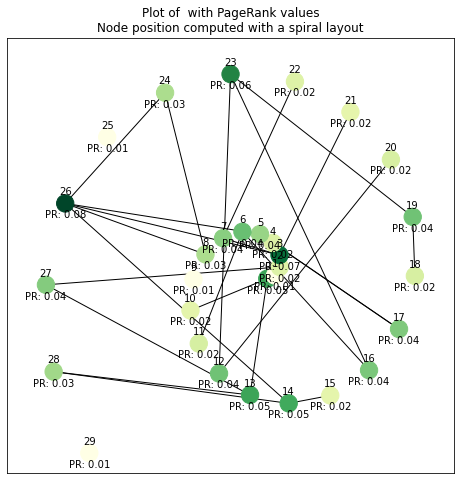

In [38]:
plot_graph(graphs_small, "spiral")

### 3.2. Building Two Graph Neural Networks

<u>GNN with relaxation</u>

<u>Convolutional GNN</u>

In [39]:
ConvGNN_model = PageRankModelingWithGNN(graph_small, 64, 1000, "GCN")

### 3.3. Training the Graph Neural Networks

<u>GNN with relaxation</u>

<u>Convolutional GNN</u>

Epoch 0, loss: 0.009630461223423481; val loss 0.0015574904391542077
Epoch 50, loss: 0.00034791952930390835; val loss 0.000492470629978925
Epoch 100, loss: 0.0001639007532503456; val loss 0.00035963975824415684
Epoch 150, loss: 0.00011661805183393881; val loss 0.0002947734610643238
Epoch 200, loss: 9.045473416335881e-05; val loss 0.00024814039352349937
Epoch 250, loss: 7.136630301829427e-05; val loss 0.00021097571880090982
Epoch 300, loss: 6.166529783513397e-05; val loss 0.0001929865247802809
Epoch 350, loss: 5.431928002508357e-05; val loss 0.00018707069102674723
Epoch 400, loss: 4.800878741662018e-05; val loss 0.00018238869961351156
Epoch 450, loss: 4.346156492829323e-05; val loss 0.00017273021512664855
Epoch 500, loss: 3.95472816308029e-05; val loss 0.00016316460096277297
Epoch 550, loss: 3.606055543059483e-05; val loss 0.00015523956972174346
Epoch 600, loss: 3.2885003747651353e-05; val loss 0.00015024548338260502
Epoch 650, loss: 2.989830682054162e-05; val loss 0.0001448671391699463


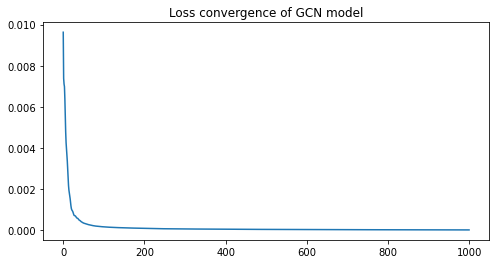

In [40]:
ConvGNN_model.train()

In [41]:
for p, t in zip([x[0] for x in ConvGNN_model.p.detach().numpy()], 
                [x.item() for x in list(ConvGNN_model.node_labels)]):
    if round(np.abs(p-t), 6) > 0.025: a = "############### "
    else: a=""
    print(round(p, 6), "\t", round(t, 6), "\t", a+str(round(np.abs(p-t), 6)))

0.045576 	 0.051597 	 0.006021
0.005748 	 0.005639 	 0.000109
0.026132 	 0.022305 	 0.003828
0.066303 	 0.066454 	 0.000151
0.033931 	 0.022691 	 0.01124
0.033183 	 0.035754 	 0.002571
0.040532 	 0.043585 	 0.003053
0.017126 	 0.038442 	 0.021316
0.030885 	 0.032526 	 0.001641
0.006193 	 0.005639 	 0.000554
0.067912 	 0.020257 	 ############### 0.047655
0.055628 	 0.024163 	 ############### 0.031466
0.041745 	 0.042627 	 0.000883
0.041338 	 0.051583 	 0.010245
0.050364 	 0.05026 	 0.000104
0.019451 	 0.01988 	 0.000429
0.049887 	 0.040959 	 0.008929
0.055591 	 0.040123 	 0.015468
0.023749 	 0.023756 	 6e-06
0.050724 	 0.042627 	 0.008097
0.041155 	 0.023756 	 0.0174
0.024246 	 0.019761 	 0.004484
0.021407 	 0.021976 	 0.000569
0.0592 	 0.05928 	 8e-05
0.031195 	 0.032526 	 0.001331
0.006384 	 0.005639 	 0.000745
0.077664 	 0.076846 	 0.000818
0.039752 	 0.039215 	 0.000537
0.055591 	 0.034496 	 0.021094
0.005557 	 0.005639 	 8.2e-05


In [42]:
preds = [x[0] for x in ConvGNN_model.p.detach().numpy()]

In [43]:
a = graph_small.ndata["label"].numpy()

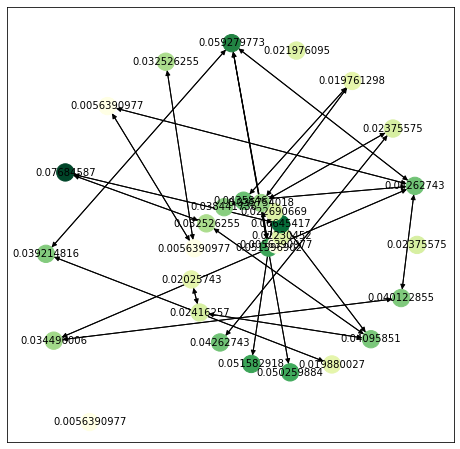

In [44]:
import matplotlib
gs = graph_small.to_networkx()
nx.set_node_attributes(
                gs, 
                preds, 
                "PageRank"
            )
matplotlib.pyplot.figure(figsize=(8,8))
nx.draw_networkx(graph_small.to_networkx(),
                 labels={k:a[k] for k in range(len(a))},
                 pos=nx.spiral_layout(graph_small.to_networkx()),
                 node_color = a,
                 font_size  = 10,
                 cmap       = matplotlib.cm.YlGn)

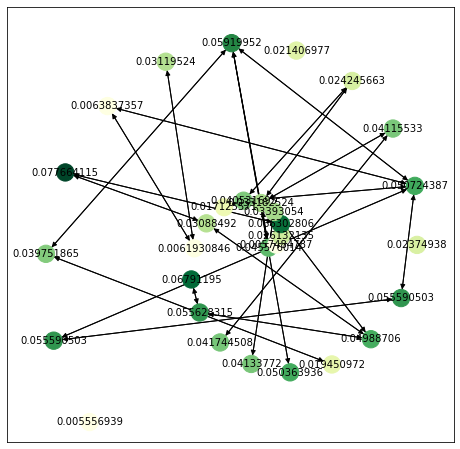

In [45]:
matplotlib.pyplot.figure(figsize=(8,8))
nx.draw_networkx(gs,
                 labels={k:preds[k] for k in range(len(preds))},
                 pos=nx.spiral_layout(gs),
                 node_color = preds,
                 font_size  = 10,
                 cmap       = matplotlib.cm.YlGn)

## 4. Discussing the Results

GraphSAGE layer from paper `Inductive Representation Learning on
Large Graphs <https://arxiv.org/pdf/1706.02216.pdf>`__.

\begin{align}
h_{\mathcal{N}(i)}^{(l+1)} &= \mathrm{aggregate}\left(\{h_{j}^{l}, \forall j \in \mathcal{N}(i) \}\right) h_{i}^{(l+1)}\\
&= \sigma \left(W \cdot \mathrm{concat} (h_{i}^{l}, h_{\mathcal{N}(i)}^{l+1}) \right) h_{i}^{(l+1)} \\
&= \mathrm{norm}(h_{i}^{l})
\end{align}

If a weight tensor on each edge is provided, the aggregation becomes:

\begin{align}
    h_{\mathcal{N}(i)}^{(l+1)} = \mathrm{aggregate}\left(\{e_{ji} h_{j}^{l}, \forall j \in \mathcal{N}(i) \}\right)
\end{align}

where :math:`e_{ji}` is the scalar weight on the edge from node :math:`j` to node :math:`i`.
Please make sure that :math:`e_{ji}` is broadcastable with :math:`h_j^{l}`.